# Spherepop Playground Notebook

Executable event-based semantics for Spherepop + RSVP.

In [1]:

import uuid
from dataclasses import dataclass, field
from typing import Callable, Any, List, Tuple, Dict
import matplotlib.pyplot as plt


## Core Spherepop Structures

In [2]:
@dataclass
class Event:
    eid: str
    label: str
    value: Any
    parents: Tuple[str, ...]

@dataclass
class History:
    events: Dict[str, Event] = field(default_factory=dict)

    def add(self, event: Event):
        self.events[event.eid] = event

    def lineage(self, eid: str) -> List[str]:
        seen = set()
        order = []
        def dfs(x):
            if x in seen: return
            seen.add(x)
            for p in self.events[x].parents:
                dfs(p)
            order.append(x)
        dfs(eid)
        return order

@dataclass
class Sphere:
    label: str
    thunk: Callable[['History'], Any]
    _eid: str = None

    def pop(self, history: History):
        if self._eid is not None:
            return history.events[self._eid].value, self._eid
        value, parents = self.thunk(history)
        eid = str(uuid.uuid4())
        history.add(Event(eid, self.label, value, parents))
        self._eid = eid
        return value, eid


## Primitive Constructors

In [3]:
def const(label, x):
    return Sphere(label, lambda h: (x, ()))

def add(label, a, b):
    def thunk(h):
        va, ea = a.pop(h)
        vb, eb = b.pop(h)
        return va + vb, (ea, eb)
    return Sphere(label, thunk)

def mul(label, a, b):
    def thunk(h):
        va, ea = a.pop(h)
        vb, eb = b.pop(h)
        return va * vb, (ea, eb)
    return Sphere(label, thunk)


## Example: (1 + 2) × 3

In [4]:
H = History()
s1 = const("one", 1)
s2 = const("two", 2)
s3 = const("three", 3)

expr = mul("mul", add("add", s1, s2), s3)
expr.pop(H)


(9, '828e8503-e193-4ae8-ad9d-7fc4e238adc2')

## Branching Histories

In [5]:
H2 = History()
base = add("base", const("x", 2), const("y", 3))
b1 = mul("b1", base, const("a", 10))
b2 = mul("b2", base, const("b", 100))

b1.pop(H2)
b2.pop(H2)

len(H2.events)


7

## RSVP Field Layer

In [6]:
@dataclass
class RSVPState:
    phi: float
    v: float
    S: float

def rsvp_const(label, phi, v, S):
    return Sphere(label, lambda h: (RSVPState(phi, v, S), ()))

def rsvp_evolve(label, a, b, alpha=0.1, beta=0.05):
    def thunk(h):
        sa, ea = a.pop(h)
        sb, eb = b.pop(h)
        phi = sa.phi + sb.phi - alpha * (sa.S + sb.S)
        v = sa.v + sb.v
        S = sa.S + sb.S + beta * abs(sa.phi - sb.phi)
        return RSVPState(phi, v, S), (ea, eb)
    return Sphere(label, thunk)


## RSVP Trajectory

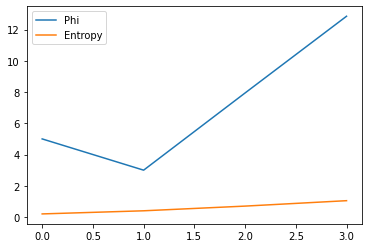

In [7]:
HR = History()
A = rsvp_const("A", 5.0, 1.0, 0.2)
B = rsvp_const("B", 3.0, -0.5, 0.4)
C = rsvp_evolve("C", A, B)
D = rsvp_evolve("D", C, A)

state, root = D.pop(HR)
traj = HR.lineage(root)

phis = [HR.events[e].value.phi for e in traj]
Ss   = [HR.events[e].value.S   for e in traj]

plt.plot(phis, label="Phi")
plt.plot(Ss, label="Entropy")
plt.legend()
plt.show()
